In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset
from IPython.display import clear_output
import torch

torch.manual_seed(0)

In [3]:
training_set = pd.read_csv('train_ts_top5.csv', index_col='item_id')

In [4]:
training_set = training_set.sum(axis=0)

In [4]:
#training_set = training_set.sum(axis=0)

training_set

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
item_id,,,,,,,,,,,,,,,,,,,,,
FOODS_1_004,0,0,0,0,0,0,0,0,0,0,...,115,104,107,81,73,62,71,75,83,93
FOODS_1_012,0,0,0,0,0,0,0,0,0,0,...,65,55,43,46,43,36,53,57,61,56
FOODS_1_018,47,26,30,24,13,18,30,32,31,16,...,104,134,146,98,92,71,99,100,128,105
FOODS_1_032,62,63,34,54,48,45,49,42,31,25,...,100,98,71,71,62,52,75,72,89,83
FOODS_1_043,0,0,0,0,0,0,0,0,0,0,...,186,109,139,104,68,54,101,115,104,128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HOUSEHOLD_1_447,0,0,0,0,0,0,0,0,0,0,...,81,85,62,76,76,56,47,77,62,34
HOUSEHOLD_1_459,0,0,0,0,0,0,0,0,0,0,...,92,149,85,84,90,89,88,119,122,100
HOUSEHOLD_1_465,0,0,0,0,0,0,0,0,0,0,...,110,139,157,106,61,62,78,108,99,91


In [5]:
training_set = training_set.T.values.reshape(-1, len(training_set))

In [6]:
training_set

array([[  0,   0,  47, ...,   0,  53,   0],
       [  0,   0,  26, ...,   0,  48,   0],
       [  0,   0,  30, ...,   0,  37,   0],
       ...,
       [ 75,  57, 100, ..., 108,  74,  44],
       [ 83,  61, 128, ...,  99,  67,  56],
       [ 93,  56, 105, ...,  91,  47,  66]])

In [7]:
train = training_set[:int(0.8 * len(training_set))]
valid = training_set[int(0.8 * len(training_set)):int(0.9 * len(training_set))]
test = training_set[int(0.9 * len(training_set)):]

In [8]:
def sliding_windows(data, seq_length, pred_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1-pred_length):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length:i+pred_length+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()

train = sc.fit_transform(train)
valid = sc.transform(valid)

seq_length = 90
pred_length = 28
x_train, y_train = sliding_windows(train, seq_length, pred_length)
x_valid, y_valid = sliding_windows(valid, seq_length, pred_length)


TrainX = Variable(torch.Tensor(np.array(x_train)))
Trainy = Variable(torch.Tensor(np.array(y_train)))
ValidX = Variable(torch.Tensor(np.array(x_valid)))
Validy = Variable(torch.Tensor(np.array(y_valid)))

In [9]:
Trainy.shape

torch.Size([1433, 28, 153])

## Encoder 

In [61]:
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim,  embedding_dim
        self.num_layers = 3
        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=3,
          batch_first=True,
          dropout = 0.3
        )
   
    def forward(self, x):
       
        x = x.reshape((-1, self.seq_len, self.n_features))
        #print(x.shape)
        
        h_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_dim))
         
        
        c_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_dim))
              
        x, (hidden, cell) = self.rnn1(x,(h_1, c_1))
        
        
        return hidden , cell 

## Decoder 

In [62]:
class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()

        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features =  input_dim, n_features
        
        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=input_dim,
          num_layers=3,
          batch_first=True,
          dropout = 0.3
        )
        
        
      
        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x, input_hidden, input_cell):
       
       
        x = x.reshape((-1, 1, self.n_features))
        #print("decode input",x.size())
             

        x, (hidden_n, cell_n) = self.rnn1(x,(input_hidden,input_cell))
        #print(x.shape)
        x = self.output_layer(x)
        #print(f'forward decoder: {x.shape}')
        return x, hidden_n, cell_n

## Seq2seq

In [63]:
class Seq2Seq(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64,output_length=1):
        super(Seq2Seq, self).__init__()

        self.encoder = Encoder(seq_len, n_features, embedding_dim)
        self.n_features = n_features
        self.output_length = output_length
        self.decoder = Decoder(seq_len, embedding_dim, n_features)
        

    def forward(self, x, prev_y):
        hidden,cell = self.encoder(x)
        
        #Prepare place holder for decoder output
        targets_ta = []
        #prev_output become the next input to the LSTM cell
        dec_input = prev_y
        

        
        #print(f'dec_input_init: {dec_input.shape}')
        #itearate over LSTM - according to the required output days
        for out_days in range(self.output_length) :
            
          
            prev_x,prev_hidden,prev_cell = self.decoder(dec_input,hidden,cell)
            hidden,cell = prev_hidden,prev_cell
            
            #print(prev_x)
            #prev_x = prev_x[:,:,0:1]
            #print("preve x shape is:",prev_x.size())
           
            dec_input = prev_x
            #print(f'dec_input: {dec_input.shape}')
            
            targets_ta.append(prev_x.reshape(-1, self.n_features))
           
            
        
        
        targets = torch.stack(targets_ta)
        
        targets = targets.reshape(-1, self.output_length, self.n_features)

        return targets

## Making dataset

In [64]:
class DatasetTs(Dataset):
    def __init__(self, X, y = None):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        assert index < len(self), 'index {} is out of bounds'.format(index)
        X = self.X[index]
        
        X = Variable(torch.tensor(X))

        
        if self.y is not None:
            return X, Variable(torch.tensor(self.y[index]))

        return X

In [65]:
train = DatasetTs(TrainX, Trainy)
valid = DatasetTs(ValidX, Validy)

In [66]:
BATCH_SIZE = 128

train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=False)
valid_loader = DataLoader(valid, batch_size=BATCH_SIZE, shuffle=False)

In [67]:
TrainX.shape[2]

153

## Train model

In [68]:
n_features = TrainX.shape[2] # number of timeseries 
hidden_dim = 60 * n_features # hidden dim
output_length = 28 # number of days to predict 

model = Seq2Seq(seq_length, n_features, hidden_dim, output_length)

model

Seq2Seq(
  (encoder): Encoder(
    (rnn1): LSTM(153, 9180, num_layers=3, batch_first=True, dropout=0.3)
  )
  (decoder): Decoder(
    (rnn1): LSTM(153, 9180, num_layers=3, batch_first=True, dropout=0.3)
    (output_layer): Linear(in_features=9180, out_features=153, bias=True)
  )
)

In [69]:
from tqdm import tqdm

In [70]:
TrainX.shape, Trainy.shape

(torch.Size([1433, 90, 153]), torch.Size([1433, 28, 153]))

In [71]:
torch.cuda.is_available()

False

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device is:",device)

device is: cpu


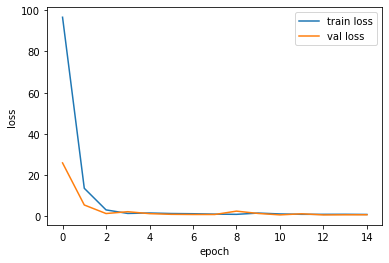

Epoch 14: train loss 0.8329746375481287 val loss 0.6791648864746094


  8%|█████████▍                                                                                                       | 1/12 [08:41<1:35:34, 521.33s/it]

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
criterion = torch.nn.MSELoss()
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5 ,min_lr=1e-3, eps=1e-08)
best_loss = 10
n_epochs = 200

history = dict(train=[], val=[])

for epoch in range(n_epochs):
    model = model.train()

    train_losses = []
    for X_train, y_train in tqdm(train_loader):
        #seq_inp = TrainX[i,:,:]
        #seq_true = Trainy[i,:,:]
        prevs_y = X_train[:, -1:, :]
        #print(X_train.shape)
        #print(X_train)
        #print(prevs_y)
        #break

        #print(f'prev_y {seq_inp[seq_length-1:seq_length,:]}')
        seq_pred = model(X_train, prevs_y)#seq_inp[seq_length-1:seq_length,:])
        #print(seq_pred.shape)
        #print(y_train.shape)
        #print(seq_pred.shape)
        #print(y_train.shape)
        optimizer.zero_grad()
        
        loss = criterion(seq_pred, y_train)
        
        #print(loss.item())
        

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()

        train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
        for X_valid, y_valid in valid_loader:
            #seq_inp = ValidX[i,:,:]
            #seq_true = Validy[i,:,:]
            prevs_y = X_valid[:, -1:, :]

            seq_pred = model(X_valid,prevs_y)

           
            loss = criterion(seq_pred, y_valid)
            val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    

    
    
    clear_output(True)

    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(history['train'], label='train loss')
    plt.plot(history['val'], label='val loss')

    plt.legend()
    plt.show()
    
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'best_model_n_features.pt')
        print("saved best model epoch:",epoch,"val loss is:",val_loss)
    
    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
    
    #scheduler.step(val_loss)

In [107]:
model = model.eval()

In [108]:
preds = []

for i in range(len(ValidX)):
    seq_inp = ValidX[i,:,:]
    seq_pred = model(seq_inp,seq_inp[seq_length-1:seq_length,:]).detach().numpy()
    
    preds.append(seq_pred)

In [109]:
predy = np.array(preds)
predy.shape

(75, 1, 28, 153)

In [50]:
valy = Validy.detach().numpy()
valy.shape

(75, 28, 153)

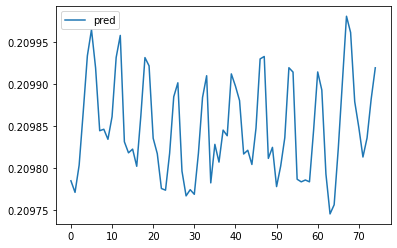

In [111]:
plt.plot(
    predy[:, 0, 0, 0],
    label='pred'
)

#plt.plot(
#    valy[:, 0, 0],
#    label='true'
#)

plt.legend()

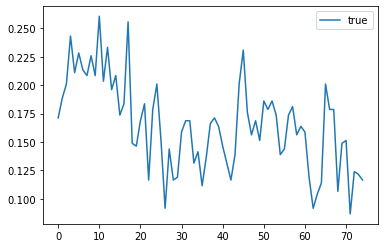

In [112]:
plt.plot(
    valy[:, 0, 0],
    label='true'
)

plt.legend()

## Grid search best params

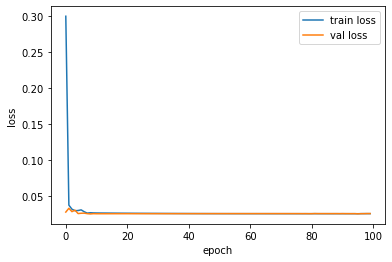

Epoch 99: train loss 0.0262331102664272 val loss 0.026355091482400894


In [40]:
best_loss = 10
lrs = [1e-2, 5e-3, 1e-3, 7e-3, 3e-3]

for lr in lrs:
    n_features = TrainX.shape[2] # number of timeseries 
    hidden_dim = 640 # hidden dim
    output_length = 28 # number of days to predict 

    model = Seq2Seq(seq_length, n_features, hidden_dim, output_length)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()

    n_epochs = 100

    history = dict(train=[], val=[])

    for epoch in range(n_epochs):
        model = model.train()

        train_losses = []
        for X_train, y_train in tqdm(train_loader):
            #seq_inp = TrainX[i,:,:]
            #seq_true = Trainy[i,:,:]
            prevs_y = X_train[:, -1:, :]
            #print(X_train.shape)
            #print(X_train)
            #print(prevs_y)
            #break

            #print(f'prev_y {seq_inp[seq_length-1:seq_length,:]}')
            seq_pred = model(X_train, prevs_y)#seq_inp[seq_length-1:seq_length,:])
            #print(seq_pred.shape)
            #print(y_train.shape)
            #print(seq_pred.shape)
            #print(y_train.shape)
            optimizer.zero_grad()

            loss = criterion(seq_pred, y_train)

            #print(loss.item())


            loss.backward()

            #torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()

            train_losses.append(loss.item())

        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for X_valid, y_valid in valid_loader:
                #seq_inp = ValidX[i,:,:]
                #seq_true = Validy[i,:,:]
                prevs_y = X_valid[:, -1:, :]

                seq_pred = model(X_valid,prevs_y)


                loss = criterion(seq_pred, y_valid)
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)





        clear_output(True)

        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.plot(history['train'], label='train loss')
        plt.plot(history['val'], label='val loss')

        plt.legend()
        plt.show()

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), f'best_model_epoch_{epoch}_lr_{lr}_loss_{val_loss}.pt')
            print("saved best model epoch:",epoch,"val loss is:",val_loss)

        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

        #scheduler.step(val_loss)

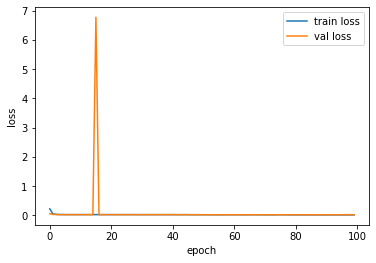

Epoch 99: train loss 0.017439514864236116 val loss 0.022354723885655403


In [41]:
lrs = [1e-2, 5e-3, 1e-3, 7e-3, 3e-3]

for lr in lrs:
    n_features = TrainX.shape[2] # number of timeseries 
    hidden_dim = 640 # hidden dim
    output_length = 28 # number of days to predict 
    
    model = Seq2Seq(seq_length, n_features, hidden_dim, output_length)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5 ,min_lr=1e-3, eps=1e-08)

    n_epochs = 100

    history = dict(train=[], val=[])

    for epoch in range(n_epochs):
        model = model.train()

        train_losses = []
        for X_train, y_train in tqdm(train_loader):
            #seq_inp = TrainX[i,:,:]
            #seq_true = Trainy[i,:,:]
            prevs_y = X_train[:, -1:, :]
            #print(X_train.shape)
            #print(X_train)
            #print(prevs_y)
            #break

            #print(f'prev_y {seq_inp[seq_length-1:seq_length,:]}')
            seq_pred = model(X_train, prevs_y)#seq_inp[seq_length-1:seq_length,:])
            #print(seq_pred.shape)
            #print(y_train.shape)
            #print(seq_pred.shape)
            #print(y_train.shape)
            optimizer.zero_grad()

            loss = criterion(seq_pred, y_train)

            #print(loss.item())


            loss.backward()

            #torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()

            train_losses.append(loss.item())

        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for X_valid, y_valid in valid_loader:
                #seq_inp = ValidX[i,:,:]
                #seq_true = Validy[i,:,:]
                prevs_y = X_valid[:, -1:, :]

                seq_pred = model(X_valid,prevs_y)


                loss = criterion(seq_pred, y_valid)
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)





        clear_output(True)

        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.plot(history['train'], label='train loss')
        plt.plot(history['val'], label='val loss')

        plt.legend()
        plt.show()

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), f'best_model_wsch_epoch_{epoch}_lr_{lr}_loss_{val_loss}.pt')
            print("saved best model epoch:",epoch,"val loss is:",val_loss)

        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

        scheduler.step(val_loss)

In [44]:
best_model = Seq2Seq(seq_length, n_features, hidden_dim, output_length)
best_model.load_state_dict(torch.load('best_model_wsch_epoch_46_lr_0.003_loss_0.02204580046236515.pt'))
best_model.eval()

Seq2Seq(
  (encoder): Encoder(
    (rnn1): LSTM(153, 640, num_layers=3, batch_first=True, dropout=0.35)
  )
  (decoder): Decoder(
    (rnn1): LSTM(153, 640, num_layers=3, batch_first=True, dropout=0.35)
    (output_layer): Linear(in_features=640, out_features=153, bias=True)
  )
)

In [46]:
preds = []

for i in range(len(ValidX)):
    seq_inp = ValidX[i,:,:]
    seq_pred = model(seq_inp,seq_inp[seq_length-1:seq_length,:]).detach().numpy()
    
    preds.append(seq_pred)

In [47]:
predy = np.array(preds)

In [56]:
predy.shape, valy.shape

((75, 1, 28, 153), (75, 28, 153))

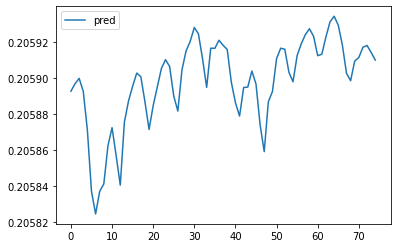

In [60]:
plt.plot(
    predy[:, 0, 27, 0],
    label='pred'
)


plt.legend()

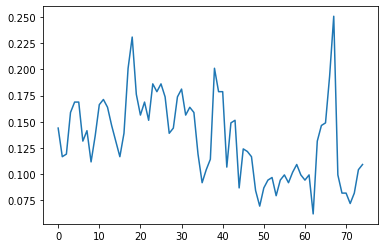

In [59]:
plt.plot(
    valy[:, 27, 0],
    label='true'
)